In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.3081

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 616ms/step - loss: 0.2490
Average validation loss: 0.6485695838928223
4/4 [==============================] - 6s 630ms/step - loss: 0.2490 - val_loss: 0.6486
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 592ms/step - loss: 0.1887 - val_loss: 0.6486
Average validation loss: 0.5661855340003967
4/4 [==============================] - 8s 612ms/step - loss: 0.1887 - val_loss: 0.6074
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 600ms/step - loss: 0.1495 - val_loss: 0.6074
Average validation loss: 0.42235711216926575
4/4 [==============================] - 11s 616ms/step - loss: 0.1495 - val_loss: 0.5457
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 718ms/step - loss: 0.0125
Average validation loss: 0.0
8/8 [==============================] - 6s 734ms/step - loss: 0.0125 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 746ms/step - loss: 0.0137 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 12s 757ms/step - loss: 0.0137 - val_loss: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 18s 745ms/step - loss: 0.0129 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 18s 755ms/step - loss: 0.0129 - val_loss: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 24s 756ms/step - loss: 0.0125 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 24s 770ms/step - loss: 0.0125 - val_loss: 0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 738ms/step - loss: 0.0142
Average validation loss: 0.0707541891862699
12/12 [==============================] - 9s 750ms/step - loss: 0.0142 - val_loss: 0.0708
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 749ms/step - loss: 0.0140 - val_loss: 0.0708
Average validation loss: 0.16509500642617544
12/12 [==============================] - 18s 763ms/step - loss: 0.0140 - val_loss: 0.1179
Epoch 3/10
12/12 [==============================] - 27s 717ms/step - loss: 0.0140 - val_loss: 0.1179
Average validation loss: 0.3212508459885915
12/12 [==============================] - 27s 730ms/step - loss: 0.0140 - val_loss: 0.1857
Epoch 4/10
12/12 [==============================] - 36s 739ms/step - loss: 0.0139 - val_loss: 0.1857
Average validation loss: 0.16396895547707876
12/12 [=======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 731ms/step - loss: 0.0132
Average validation loss: 0.23541886365023854
16/16 [==============================] - 12s 744ms/step - loss: 0.0132 - val_loss: 0.2354
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 758ms/step - loss: 0.0133 - val_loss: 0.2354
Average validation loss: 0.10312532995040069
16/16 [==============================] - 24s 772ms/step - loss: 0.0133 - val_loss: 0.1693
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 755ms/step - loss: 0.0130 - val_loss: 0.1693
Average validation loss: 0.2787098704412756
16/16 [==============================] - 37s 769ms/step - loss: 0.0130 - val_loss: 0.2058
Epoch 4/10
16/16 [=====

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 732ms/step - loss: 0.0081
Average validation loss: 0.16089896390078878
20/20 [==============================] - 15s 745ms/step - loss: 0.0081 - val_loss: 0.1609
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 716ms/step - loss: 0.0080 - val_loss: 0.1609
Average validation loss: 0.07665105825290083
20/20 [==============================] - 30s 728ms/step - loss: 0.0080 - val_loss: 0.1188
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 726ms/step - loss: 0.0078 - val_loss: 0.1188
Average validation loss: 0.04320373402151745
20/20 [==============================] - 44s 738ms/step - loss: 0.0078 - val_loss: 0.0936
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 729ms/step - loss: 0.0092
Average validation loss: 0.3356228868166606
24/24 [==============================] - 18s 741ms/step - loss: 0.0092 - val_loss: 0.3356
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 728ms/step - loss: 0.0086 - val_loss: 0.3356
Average validation loss: 0.02846979194631179
24/24 [==============================] - 36s 740ms/step - loss: 0.0086 - val_loss: 0.1820
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 714ms/step - loss: 0.0083 - val_loss: 0.1820
Average validation loss: 0.08925653869907062
24/24 [==============================] - 53s 726ms/step - loss: 0.0083 - val_loss: 0.1511
Epoch 4/10
24/24 [=====

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 729ms/step - loss: 0.0110
Average validation loss: 0.22675784528255463
40/40 [==============================] - 30s 742ms/step - loss: 0.0110 - val_loss: 0.2268
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 731ms/step - loss: 0.0103 - val_loss: 0.2268
Average validation loss: 0.04503940362483263
40/40 [==============================] - 59s 744ms/step - loss: 0.0103 - val_loss: 0.1359
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 726ms/step - loss: 0.0102 - val_loss: 0.1359
Average validation loss: 0.32554376423358916
40/40 [==============================] - 89s 739ms/step - loss: 0.0102 - val_loss: 0.1991
Epoch 4/10
40/40 [====

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 36s 745ms/step - loss: 0.0092
Average validation loss: 0.03475241490450685
48/48 [==============================] - 36s 758ms/step - loss: 0.0092 - val_loss: 0.0348
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 71s 718ms/step - loss: 0.0076 - val_loss: 0.0348
Average validation loss: 0.031204667894764764
48/48 [==============================] - 72s 731ms/step - loss: 0.0076 - val_loss: 0.0330
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 107s 731ms/step - loss: 0.0068 - val_loss: 0.0330
Average validation loss: 0.01657265759140819
48/48 [==============================] - 107s 744ms/step - loss: 0.0068 - val_loss: 0.0275
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 739ms/step - loss: 0.0076
Average validation loss: 0.04328646825290759
56/56 [==============================] - 42s 753ms/step - loss: 0.0076 - val_loss: 0.0433
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 83s 735ms/step - loss: 0.0066 - val_loss: 0.0433
Average validation loss: 0.01618389448997602
56/56 [==============================] - 84s 747ms/step - loss: 0.0066 - val_loss: 0.0297
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 125s 726ms/step - loss: 0.0058 - val_loss: 0.0297
Average validation loss: 0.029257994608737396
56/56 [==============================] - 126s 738ms/step - loss: 0.0058 - val_loss: 0.0296
Epoch 4/10
56/56 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 722ms/step - loss: 0.0066
Average validation loss: 0.18750899145379663
64/64 [==============================] - 47s 735ms/step - loss: 0.0066 - val_loss: 0.1875
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 94s 727ms/step - loss: 0.0054 - val_loss: 0.1875
Average validation loss: 0.06702840421377232
64/64 [==============================] - 94s 740ms/step - loss: 0.0054 - val_loss: 0.1273
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 718ms/step - loss: 0.0046 - val_loss: 0.1273
Average validation loss: 0.07018108596115269
64/64 [==============================] - 141s 731ms/step - loss: 0.0046 - val_loss: 0.1082
Epoch 4/10
64/64 [==

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 53s 728ms/step - loss: 0.0056
Average validation loss: 0.121687527332041
72/72 [==============================] - 54s 741ms/step - loss: 0.0056 - val_loss: 0.1217
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 720ms/step - loss: 0.0046 - val_loss: 0.1217
Average validation loss: 0.03450636891648173
72/72 [==============================] - 106s 732ms/step - loss: 0.0046 - val_loss: 0.0781
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 159s 723ms/step - loss: 0.0039 - val_loss: 0.0781
Average validation loss: 0.009141536895185709
72/72 [==============================] - 159s 736ms/step - loss: 0.0039 - val_loss: 0.0551
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 723ms/step - loss: 0.0054
Average validation loss: 0.01129195720423013
80/80 [==============================] - 59s 736ms/step - loss: 0.0054 - val_loss: 0.0113
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 723ms/step - loss: 0.0043 - val_loss: 0.0113
Average validation loss: 0.0090003673103638
80/80 [==============================] - 118s 735ms/step - loss: 0.0043 - val_loss: 0.0101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 718ms/step - loss: 0.0036 - val_loss: 0.0101
Average validation loss: 0.006865480507258326
80/80 [==============================] - 176s 731ms/step - loss: 0.0036 - val_loss: 0.0091
Saved model weig

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 721ms/step - loss: 0.0070
Average validation loss: 0.021148847477855656
96/96 [==============================] - 71s 735ms/step - loss: 0.0070 - val_loss: 0.0211
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 721ms/step - loss: 0.0054 - val_loss: 0.0211
Average validation loss: 0.020806257008424645
96/96 [==============================] - 141s 734ms/step - loss: 0.0054 - val_loss: 0.0210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 210s 719ms/step - loss: 0.0046 - val_loss: 0.0210
Average validation loss: 0.026327586057017047
96/96 [==============================] - 211s 732ms/step - loss: 0.0046 - val_loss: 0.0228
Epoch 4/10
96

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 718ms/step - loss: 0.0058
Average validation loss: 0.2625222494204839
120/120 [==============================] - 88s 731ms/step - loss: 0.0058 - val_loss: 0.2625
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 717ms/step - loss: 0.0047 - val_loss: 0.2625
Average validation loss: 0.023541016869606798
120/120 [==============================] - 175s 730ms/step - loss: 0.0047 - val_loss: 0.1430
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 262s 719ms/step - loss: 0.0041 - val_loss: 0.1430
Average validation loss: 0.007317299690718452
120/120 [==============================] - 263s 732ms/step - loss: 0.0041 - val_loss: 0.0978
Sav

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 725ms/step - loss: 0.0049
Average validation loss: 0.017929196819219822
144/144 [==============================] - 106s 737ms/step - loss: 0.0049 - val_loss: 0.0179
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 718ms/step - loss: 0.0039 - val_loss: 0.0179
Average validation loss: 0.02034128751819253
144/144 [==============================] - 212s 731ms/step - loss: 0.0039 - val_loss: 0.0191
Epoch 3/10
144/144 [==============================] - 315s 720ms/step - loss: 0.0033 - val_loss: 0.0191
Average validation loss: 0.009034407830768032
144/144 [==============================] - 317s 733ms/step - loss: 0.0033 - val_loss: 0.0158
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_180.pth'.


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 134s 839ms/step - loss: 0.0032
Average validation loss: 0.04714358986626087
160/160 [==============================] - 136s 853ms/step - loss: 0.0032 - val_loss: 0.0471
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 282s 910ms/step - loss: 0.0025 - val_loss: 0.0471
Average validation loss: 0.037392599871295285
160/160 [==============================] - 284s 924ms/step - loss: 0.0025 - val_loss: 0.0423
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 417s 828ms/step - loss: 0.0022 - val_loss: 0.0423
Average validation loss: 0.2428476806824767
160/160 [==============================] - 419s 841ms/step - loss: 0.0022 - val_loss: 0.1091
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 721ms/step - loss: 0.0057
Average validation loss: 0.009147400355432182
200/200 [==============================] - 147s 733ms/step - loss: 0.0057 - val_loss: 0.0091
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 720ms/step - loss: 0.0045 - val_loss: 0.0091
Average validation loss: 0.007353936017025262
200/200 [==============================] - 293s 732ms/step - loss: 0.0045 - val_loss: 0.0083
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 437s 720ms/step - loss: 0.0039 - val_loss: 0.0083
Average validation loss: 0.14727103672921657
200/200 [==============================] - 440s 732ms/step - loss: 0.0039 - val_loss: 0.0546


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:00 - loss: 0.0011

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 720ms/step - loss: 0.0036
Average validation loss: 0.027480279491248892
240/240 [==============================] - 176s 733ms/step - loss: 0.0036 - val_loss: 0.0275
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 722ms/step - loss: 0.0029 - val_loss: 0.0275
Average validation loss: 0.07889437251380199
240/240 [==============================] - 352s 734ms/step - loss: 0.0029 - val_loss: 0.0532
Epoch 3/10
240/240 [==============================] - 525s 722ms/step - loss: 0.0027 - val_loss: 0.0532
Average validation loss: 0.014257697189448967
240/240 [==============================] - 528s 735ms/step - loss: 0.0027 - val_loss: 0.0402
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_60\segformer_data_size_300.pth'.


train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08456578595175264, 0.11566944756528107, 0.16136603414405, 0.2280669752833455, 0.13789113753215343, 0.09850084956279767, 0.07001440297661528, 0.03198387729344529, 0.06762526701763168, 0.03631716800255997, 0.035173208087697236, 0.01102974926557457, 0.016066079200967334, 0.018078353970179616, 0.02960276166377374, 0.028225398102103335, 0.015782104569268134, 0.014796078067434128]
std_val_losses =  [0.14273519851259434, 0.12727483350582586, 0.10457475270426504, 0.2490648805192132, 0.18031835176848698, 0.1113085428480725, 0.07847517636122855, 0.035015860682483406, 0.1346093915438166, 0.06210713036902001, 0.05560856698411333, 0.013975739766338228, 0.018711801397866816, 0.03665010566198982, 0.04451939399937171, 0.04209580717201365, 0.023866063809578803, 0.020489865990955283]


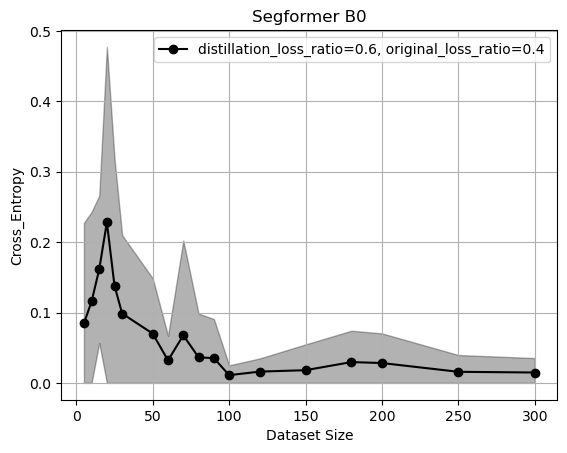

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()